# 1 Introduction

The Northwind Traders are a fictitious company sourcing specialty foods from around the world. Their database holds information about shipping information, order details and employee/customer relationships. For this project, we are interested in **determining whether or not discount amount has a statistically significant effect on the amount of product ordered**. Additionally, we would like to **quantify the level at which the discount amount is significant, if such a relationship exists**.

### 1.1 Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline

### 1.2 Retrieving data from database

In [10]:
# store results in a dataframe
orders = pd.read_csv('orders_table_northwind.csv', header=None,names = ['OrderID','ProductID','UnitPrice','Quantity','Discount'])
orders.head()

,OrderID,ProductID,UnitPrice,Quantity,Discount
0,10260,62,39.4,15,0.25
1,10260,70,12.0,21,0.25
2,10260,41,7.7,16,0.25
3,10263,16,13.9,60,0.25
4,10263,30,20.7,60,0.25


The **OrderDetail** table contains information with the variables of interest: **discount amount** and **quantity**. Note how that a single order, as denoted by the OrderID, can have multiple products within it. For example, Order #10260 has 3 products (41, 62, 70) associated with it.

### 1.3 Data structure and content

In [11]:
orders.isna().sum()

OrderID      0
ProductID    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 5 columns):
OrderID      2155 non-null int64
ProductID    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3)
memory usage: 84.3 KB


A simple check shows no missing values in the dataset and all data columns are appropriately formatted. In total, there are 6 variables and 2155 entries.

In [13]:
orders.describe()

,OrderID,ProductID,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.238135,23.843619,0.056167
std,241.378032,22.159019,29.844609,19.061357,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


The mean quantity ordered is 23.8 items and the highest number of items ordered is 130 while the lowest is 1. Customers receive a mean discount of roughly 5% while the largest discount applied was 25%. Let's visualize the distribution of quantity of items ordered.

C:\Users\misba\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'quantity of product ordered')

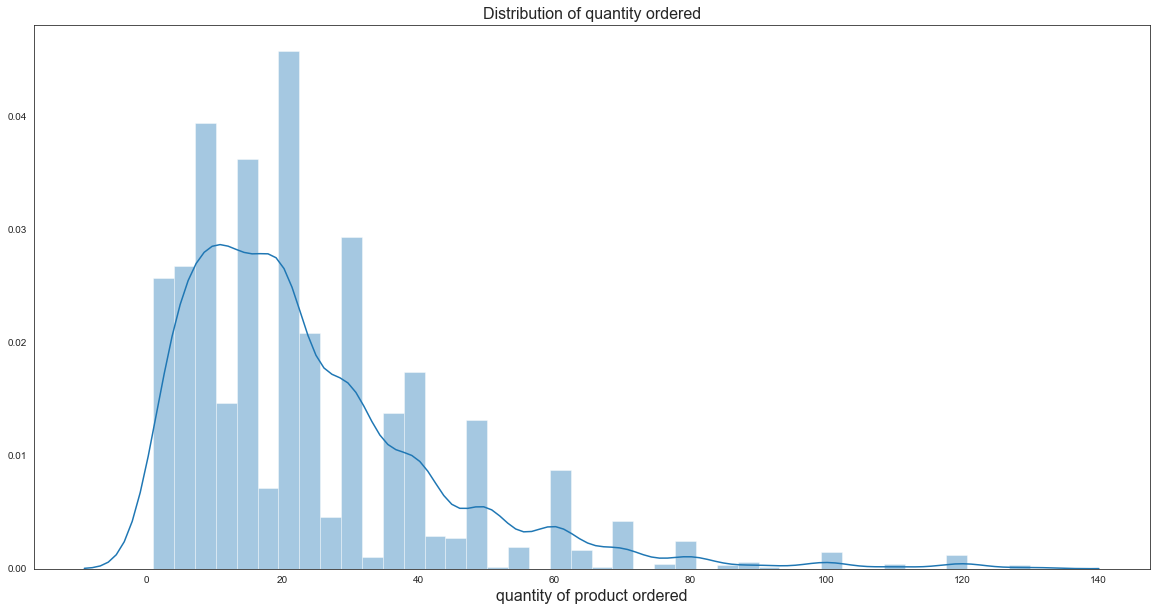

In [14]:
sns.set_style('white')

plt.figure(figsize=(20, 10))
sns.distplot(orders['Quantity'])
plt.title('Distribution of quantity ordered', fontsize=16)
plt.xlabel('quantity of product ordered', fontsize=16)

The distribution is skewed right and non-normal, so we will rely heavily on the Central Limit Theorem (CLT) for parameter estimation and hypothesis testing.

# 2 Experiment design

### 2.1 Setting up control and experimental groups

We are interested in testing whether a discount affects customer shopping behavior. More specifically, we want to test whether discount amount has a statistically significant effect on the amount of product ordered. In order to do this, we need to design this experiment with a control and experimental group to measure the effect of discount (or lack of) on quantity ordered.

* The **control** group is comprised of customers who did not receive a discount.
* The **experimental** group is comprised of customers who did receive a discount.

In [15]:
# create control and experimental groups
control = orders[orders['Discount'] == 0]
control = control['Quantity']
exp = orders[orders['Discount'] != 0]
exp = exp['Quantity']

### 2.2 Checking assumptions

### 2.2.1 Normality

In order to perform a two-sample *t*-test, there are several assumptions that need to be met, the first of which is normality. We will assess this visually and also perform a normality test using the `normaltest` [function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest), which combines measures of skew and kurtosis. 

In [ ]:
plt.figure(figsize=(20, 10))
sns.distplot(control, label='Control')
sns.distplot(exp, label='Experimental')
plt.title('Distribution of quantity ordered', fontsize=16)
plt.xlabel('quantity of product ordered', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

In [ ]:
import scipy.stats as stat

print('Normality of distribution: ', stat.normaltest(control))
print('Normality of distribution: ', stat.normaltest(exp))

As we can see, both distributions are non-normal and skewed right. It is interesting to note that they are roughly the same shape, but the mean is shifted farther to the right in the experimental group. Whether this shift is significant remains to be seen, but at least we can tell there is a difference. Next, the normality function tests the null hypothesis that the distributions are normal. Given the extremely low *p*-value, we have strong evidence against the distributions being normal. These distribution shapes are expected though because it is more likely someone orders 15 items versus >100 items (no matter how delicious the Turkish delights may be!).

Given the non-normal distributions, we will lean on the CLT for parameter estimation and hypothesis testing. Simply put, the CLT asserts that the sampling distribution of the sample mean will be approximately normal regardless of the distribution of the underlying sample. Because we have a sufficiently large sample size *n* (>30) for each group, we can be confident in our approximation despite the skewed distributions. We will create our sample distribution of sample means after checking all assumptions.

### 2.2.2 Independence

The next assumption is independence both within and between groups. This assumption is easily satisfied because the quantity of items ordered by one shopper has no influence on the next shopper.

### 2.2.3 Random

The last assumption is that samples are randomly chosen, meaning every observation has an equal chance of being selected. When we create the sampling distribution of sample mean, we will use numpy's `random.choice` function to ensure a random sample is generated (read [here](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html) for more details).

### 2.3 Creating a sampling distribution of sample mean

As mentioned earlier, the CLT allows us to create an approximately normal sampling distribution of the sample mean due to the sufficiently large sample size *n*, thus satisfying the normality assumption.

In [ ]:
# create function to sample with replacement
def get_sample(df, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# combine functions to create a sample distribution
# create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
        
    return sample_dist

In [ ]:
# create sample distributions of sample mean for control and experimental
ctrl_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(exp)

In [ ]:
plt.figure(figsize = (20, 10))
sns.distplot(ctrl_sample, label='Control')
sns.distplot(exp_sample, label='Experimental')
plt.title('Sampling distributions of sample mean', fontsize=16)
plt.xlabel('quantity of product ordered', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

Thanks to the CLT, the sampling distributions are normal now. We observe a clear difference in the mean quantity of product ordered (~22 for the control versus ~27 for the experimental) between the two groups, with minimal overlap.

# 3 Two sample *t*-test

### 3.1 Hypotheses and Type I & II errors

The null and alternative hypotheses are as follows:

$H_o:$ There is no difference in the mean quantity of product ordered when comparing customers who did not receive a discount and customers with a discount


$H_a:$ The mean quantity of product ordered by customers who received a discount should be greater than 21.7, the mean quantity of product ordered by customers without a discount

We set the significance level ($\alpha$) to 0.05 or 5%. In other words, this is the $\alpha$ value we are comfortable with for making a Type I error which we consider to be more serious than a Type II error. It is important to identify these errors early on so we can improve the test design. With this in mind, what we are trying to do is minimize the probability of committing a Type I error by maximizing the power (probability of making the correct decision when $H_a$ is true). This is one of the reasons why we chose a large sample size.

**Type I error**: reject 'discount amount has no effect' when it has no effect (i.e. keep offering discounts when it has no effect, resulting in lower revenue)

**Type II error**: accept 'discount amount has no effect' when it does have an effect (i.e. offer no discounts when it actually has an effect on quantity of product ordered, fail to capture potential revenue)

### 3.2 Welch's *t*-test

To determine whether to use a Student or Welch's *t*-test, we test whether the sample size and population variances are equal. If the population variance assumption is violated, then we use Welch's adaptation.

In [ ]:
# test whether variances are equal
np.var(control) == np.var(exp)

Because the two population variances are not equal, we perform Welch's *t*-test using the `ttest_ind` function (read [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) for more details).

In [ ]:
# set equal_var to False to perform Welch's t-test
stat.ttest_ind(exp_sample, ctrl_sample, equal_var=False)

The `ttest_ind` function returns a two-tailed p-value. In order to obtain the right-tailed value, we simply divide the two-tailed value by two. In this scenario, the p-value remains zero. The probability of getting a test statistic of 140 or higher, if in fact the null hypothesis is true, is 0. In other words, the null hypothesis provides a very poor explanation of the data and **we find strong evidence that the quantity of product ordered is significantly greater than 21.7 items when a discount is applied**. The result confirms our intuition that people are likely to purchase more when a discount is available, in order to maximize savings.

### 3.3 Effect size

We also need to calculate the magnitude of the difference (effect size) because when the results are statistically significant, it is also important to examine the practical significance. Our results may be significant due to a very large sample size, thus measuring the effect size - which is immune to sample size - allows us to determine if the difference is large enough to be meaningful. This is measured using Cohen's *d* where values of 0 - 0.2 have little or no effect and values of >= 0.8 have a large effect size.

In [ ]:
# function for calculating Cohen's d
def Cohen_d(group1, group2):

    diff = group1.mean()-group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1*var1+n2*var2) / (n1+n2)
  
    d = diff / np.sqrt(pooled_var)
    
    return d

# calculate Cohen's d for target and control samples
print("Cohen's d:" , Cohen_d(np.array(exp_sample), np.array(ctrl_sample)))

Our Cohen's d value is much higher than 0.8 so we **interpret our results as having a large effect size**, which supports the conclusion from the hypothesis test.

### 3.4 One-way ANOVA

Now that we know discount amount has a statistically significant effect on the quantity of product ordered, we are interested in the discount level at which we observe significance. Does a 5% discount have the same effect on quantity of product ordered as a 20% discount? To achieve this, we will perform a one-way ANOVA to test for differences among the different discount levels.

In [ ]:
orders['Quantity'].groupby(orders['Discount']).describe()

There are 10 discount levels, with the minimum being a 1% discount and the maximum, a 25% discount. For three levels (1%, 4% and 6%), only 1 shopper each received these discounts. We will use [statsmodels](https://www.statsmodels.org/stable/index.html) to get a bit more information from the ANOVA model. Before beginning, there are three primary assumptions we check prior to conducting an ANOVA:

1. The response variables (discount level) have a normal population distribution. 
2. The population variances are equal.
3. The response variables are independent.

The first two assumptions are violated but they are not considered serious because the sampling distribution is quite robust, given the large sample size. As a result we can proceed with the ANOVA test.

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# wrap with C() to indicate categorical variable
results = ols('Quantity ~ C(Discount)', data=orders).fit()

In [ ]:
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

The overall model is significant, *p* = 4.7e-09, which indicates a significant difference between group means but it does not provide any statistical evidence as to which means are statistically different. We need to perform a multiple comparisons analysis to determine which discount levels have a statistically significant effect on the quantity of product in an order. To do this, compare all possible pairwise means using Tukey's HSD test (read more about it [here](https://en.wikipedia.org/wiki/Tukey%27s_range_test)). 

In [ ]:
mc = MultiComparison(orders['Quantity'], orders['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)

Remember the null hypothesis is that there are no differences between the means. Looking at the results, we reject the null hypothesis at the 5, 15, 20 and 25% discount level when compared with the control group. In other words, **when discounts of 5, 15, 20 and 25% are applied, we observe a statistically significant effect on the quantity of product ordered**.

# 4 More hypothesis tests

In addition to addressing our main hypothesis, there are several other questions that we are interested in answering which may be of value to the Northwind Traders.

### 4.1 Does supply region have a statistically significant effect on unit price?

The company may be motivated to discover if the supply region has a statistically significant effect on unit price. If a product is more expensive in one region, then the company should try to source the product from a different region where the price is lower. 

The null and alternative hypotheses are as follows:

$H_o:$ There is no difference in the mean unit price among regions

$H_a:$ There is at least one region with a different mean unit price

In [ ]:
c.execute('''SELECT Region, UnitPrice
             FROM Supplier
             JOIN Product
             ON SupplierID;''')

supply = pd.DataFrame(c.fetchall())
supply.columns = [i[0] for i in c.description]
supply['Region'].value_counts()

In [ ]:
results = ols('UnitPrice ~ C(Region)', data=supply).fit()
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

The overall model is not significant, p = 1, which indicates a non-significant difference between group means. As a result, we accept the null hypothesis that there is **no significant difference in mean unit price between regions and reject the alternative hypothesis**. This is surprising because each region produces some specialty items which leads one to believe that there would be a difference in unit price. For example, one region may produce goods that are unique to that area and as a result, they can charge a higher unit price. But it is not true in this scenario, which may imply regions are more interconnected than it seems.

### 4.2 Is the mean freight price significantly different between shipping companies?

In [ ]:
c.execute('''SELECT CompanyName, Freight, "Order".ID
             FROM Shipper
             JOIN "Order"
             ON Shipper.ID = ShipVia;''')

freight = pd.DataFrame(c.fetchall())
freight.columns = [i[0] for i in c.description]
freight.head()

In [ ]:
freight['CompanyName'].value_counts()

In this example, we will only look at mean freight prices between Federal Shipping and Speedy Express. Instead of performing a right-tailed test, we will conduct a **two-tailed test** this time.

The null and alternative hypotheses are as follows:

$H_o:$ There is no difference in the mean freight price between Federal Shipping and Speedy Express

$H_a:$ There is a difference in the mean freight price between Federal Shipping and Speedy Express

In [ ]:
# create two populations
fedship = freight[freight['CompanyName'] == 'Federal Shipping']
fedship = fedship['Freight']
speedship = freight[freight['CompanyName'] != 'Speedy Express']
speedship = speedship['Freight']

In [ ]:
# check for normality
plt.figure(figsize=(20, 10))
sns.distplot(fedship, label='Federal Shipping')
sns.distplot(speedship, label='Speedy Express')
plt.title('Distribution of freight price', fontsize=16)
plt.xlabel('freight price', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

In [ ]:
# create sampling distribution of sample mean, use sample size of 200
f_ship = create_sample_distribution(fedship, n=200)
s_ship = create_sample_distribution(speedship, n=200)

In [ ]:
# test population variances to determine which t-test to use
np.var(fedship) == np.var(speedship)

In [ ]:
# set equal_var to False to perform Welch's t-test
stat.ttest_ind(s_ship, f_ship, equal_var=False)

In [ ]:
# calculate effect size
print("Cohen's d:" , Cohen_d(np.array(s_ship), np.array(f_ship)))

The probability of getting a test statistic of 9.88, if in fact the null hypothesis is true, is 1.6e-22. In other words, we reject the null hypothesis and **we find strong evidence that the mean freight price is significantly different between Speedy Express and Federal Shipping**. However, while our result is statistically significant, we interpret Cohen's d-value as only having a medium effect size (0.2 - 0.5). This highlights the importance of examining the effect size, especially when the difference is small, because very small differences will be statistically significant with a large sample size. In conclusion, it may be worth considering one shipping carrier versus the other to select the carrier with the lowest freight price.

### 4.3 Is there a statistical difference in the mean quantity of products ordered by customers from Eastern Europe?

In [ ]:
c.execute('''SELECT Region, Quantity, OrderId
             FROM Customer
             LEFT JOIN "Order"
             ON Customer.Id
             LEFT JOIN OrderDetail
             ON OrderId;''')

cust = pd.DataFrame(c.fetchall())
cust.columns = [i[0] for i in c.description]
cust.head()

In [ ]:
cust['Region'].value_counts()

In [ ]:
cust.describe()

The mean amount of product ordered across all regions is 23.8. When we look at the quantity of items ordered by region, customers from Eastern Europe have the lowest total order volume. Is the mean quantity of items ordered by customers in Eastern Europe significantly lower than the population mean? If so, the company may want to increase marketing in Eastern Europe to drive more sales because it would mean there is space for growth. To answer this question, we perform a **left-tailed test** using the `ttest_1samp` function (read more about it [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html)).

The null and alternative hypotheses are as follows:

$H_o:$ The mean quantity of product ordered in Eastern Europe is 23.8

$H_a:$ The mean quantity of product ordered in Eastern Europe is less than 23.8

In [ ]:
east = cust[cust['Region'] == 'Eastern Europe']
east = east['Quantity']

In [ ]:
# check for normality
plt.figure(figsize=(20, 10))
sns.distplot(east, label='Eastern Europe')
plt.title('Distribution of quantity ordered in Eastern Europe', fontsize=16)
plt.xlabel('quantity ordered', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

In [ ]:
# create sample
east_samp = create_sample_distribution(east)

# perform one-sample t-test
stat.ttest_1samp(east_samp, popmean=23.8)

In [ ]:
# calculate effect size
d = (np.mean(east_samp)-23.8) / np.std(east_samp)
print('Cohens d:', d)

The probability of getting a test statistic of -0.167, if in fact the null hypothesis is true, is 0.434 (remember to divide by two to get the p-value since `ttest_1samp` returns a two-tailed p-value). In other words, we **fail to reject the null hypothesis and we find strong evidence against the mean quantity of product ordered in Eastern Europe is less than the population mean**. The Cohen's d-value is also negligible, lending support to the results of the one-sample t-test. Even though customers from Eastern Europe don't order with the same frequency as their neighbors, their mean quantity per order is not significantly different. In aggregate, they simply make fewer orders.

# 5 Conclusion

In summary, we find:

* strong statistical evidence for a large and significant effect on the quantity of product ordered when discount amounts of 5, 15, 20 and 25% are applied
* insufficient evidence for a significant difference in mean unit prices among supply regions
* mild evidence for a significant difference in mean freight price between Federal Shipping and Speedy Express, making it worthwhile to choose a carrier with consistently lower prices
* a lack of evidence for a difference in mean quantity of product ordered between customers in Western and Eastern Europe

Building off of this project, more potential value can be gained by exploring the following topics:

* removing discount amounts < 5% and removing 10% discount because no value is gained. Try experimenting with discount's larger than 25% to determine whether customers will continue to order more products per order
* determine which shipping carrier has the lowest mean freight price. At the moment, we only know that there is a significant difference in price, but we don't know which carrier is the best